# 1. Import the dataset

Using the `pandas` link from HuggingFace.

Note that you have to run this every time (Colab does not save variables)

In [9]:
import pandas as pd
import tqdm as notebook_tqdm
spotify = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

In [11]:
# import some libraries
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

Matplotlib is building the font cache; this may take a moment.


# 2. Getting started

Print out the columns of the dataset.
Print out the first 20 rows of the dataset.

In [ ]:
spotify.columns
# spotify.head(20)

In [ ]:
# Get 20 random rows
spotify.sample(20)

In [ ]:
# Check the shape of spotify dataset
spotify.shape

In [ ]:
# Sanity check: get the counts of each artist and track_name combination
counts = spotify.groupby(['artists', 'track_name']).size().reset_index(name='count')
print(counts)
print("There are " + str(sum(counts['count'] != 1)) + " artist, track_name combinations that are non-unique.")

## Sanity checks!

- Are there any entries with null values
- Do numbers fall in the expected range


In [ ]:
# popularity between 0 and 100
sum(spotify['popularity'] < 0) + sum(spotify['popularity'] > 100)

In [ ]:
# danceability between 0.0 and 1.0
sum(spotify['danceability'] < 0.0) + sum(spotify['danceability'] > 1.0)

In [ ]:
# energy is between 0.0 to 1.0
sum(spotify['energy'] < 0.0) + sum(spotify['energy'] > 1.0)

In [ ]:
# mode is 0 or 1
sum(x not in [0,1] for x in spotify['mode'])

In [ ]:
# speechiness between 0.0 and 1.0
sum(spotify['speechiness'] < 0.0) + sum(spotify['speechiness'] > 1.0)

In [ ]:
# acousticness between 0.0 and 1.0
sum(spotify['acousticness'] < 0.0) + sum(spotify['acousticness'] > 1.0)

In [ ]:
# instrumentalness between 0.0 and 1.0
sum(spotify['instrumentalness'] < 0.0) + sum(spotify['instrumentalness'] > 1.0)

In [ ]:
# liveness between 0.0 and 1.0
sum(spotify['liveness'] < 0.0) + sum(spotify['liveness'] > 1.0)

In [ ]:
# valence between 0.0 and 1.0
sum(spotify['valence'] < 0.0) + sum(spotify['valence'] > 1.0)

In [ ]:
# positive tempo
sum(spotify['tempo'] < 0.0)

In [ ]:
# time signature between 3 and 7 (inclusive)
sum(spotify['time_signature'] < 3) + sum(spotify['time_signature'] > 7)

## Let's visualize some missing values!

In [ ]:
# identify whether each tempo value is zero
# and group by genre (index)
# count number of zero values
zero_tempo_by_genre = spotify.set_index("track_genre")["tempo"].eq(0).groupby(level=0).sum()

# Convert the result to a DataFrame 
zero_tempo_by_genre_df = zero_tempo_by_genre.reset_index()

# Create a bar chart 
px.bar(zero_tempo_by_genre_df,
       x='track_genre',
       y='tempo',  # The count of zero tempo values
       labels={'0': 'Number of zero tempo values', 'genre': 'Genre'},
       title="Zero Tempo Values by Genre")

In [ ]:
# identify whether each valence value is zero
# and group by genre (index)
# count number of zero values
zero_valence_by_genre = spotify.set_index("track_genre")["valence"].eq(0).groupby(level=0).sum()

# Convert the result to a DataFrame 
zero_valence_by_genre_df = zero_valence_by_genre.reset_index()

# Create a bar chart 
px.bar(zero_valence_by_genre_df,
       x='track_genre',
       y='valence',  # The count of zero valence values
       labels={'0': 'Number of zero valence values', 'genre': 'Genre'},
       title="Zero Valence Values by Genre")

In [ ]:
# Filter time_signatures for values that are either less than 3 or greater than 7
invalid_time_signatures = spotify.set_index("track_genre")["time_signature"] \
    .apply(lambda x: x < 3 or x > 7)  # Create a boolean series where True indicates invalid values

# Group by track_genre and sum the invalid counts
time_signatures = invalid_time_signatures.groupby(level=0).sum()

time_signatures_df = time_signatures.reset_index()

# Create a bar chart 
px.bar(time_signatures_df,
       x = 'track_genre',
       y='time_signature',  # The count of invalid time signature values
       labels={'0': 'Number of invalid time signatures', 'genre': 'Genre'},
       title="Invalid Time Signature by Genre")


# 3. Data cleaning

- Remove duplicate rows (same artist, same song, different genre or album)
  - These will have different track IDs
- Replace missing values
- Remove "Unnamed: 0" column (which is just the row number)

- Missing value:
  - Explicit = unknown
  - Key = -1

- Time signatures < 3 and > 7
  - Time signature of 0, usually means "sleep" genre

Warning: try not to use `inPlace = True` because it will modify the original DataFrame. For example, if you `drop_duplicates inPlace`, the original spotify DataFrame will now never contain duplicates.

`drop_duplicates` has a `subset` argument. It will consider two rows duplicates if they have the same values for `subset`.

In [ ]:
# Remove duplicate rows (the same song by same artist under different genre or album)
spotify_new = spotify.drop_duplicates(subset=['artists', 'track_name'], keep='first')
spotify_new.shape

In [ ]:
# Imputation for rows with missing values


# Exploratory Data Analysis (EDA)

## Examining relationships between single variables

### Danceability and Energy

Danceability describes how easy it is to dance to a song, while energy measures how intense and active a track is. One would expect these to have a positive correlation, which the graph shows to a small extent.

Text(0.5, 1.0, 'Energy and Danceability of Spotify Tracks')

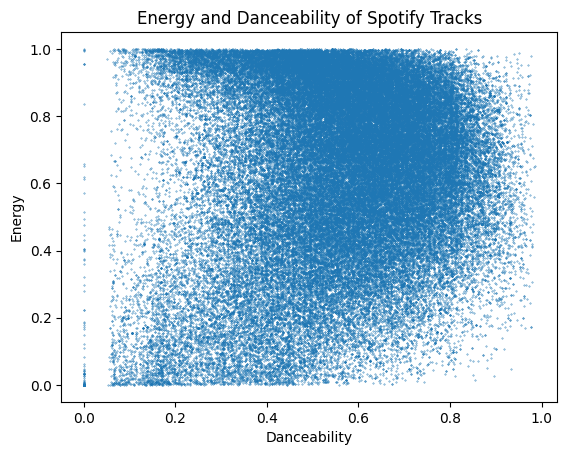

In [17]:
danceability = spotify['danceability']
energy = spotify['energy']
plt.scatter(danceability, energy, s=0.1)
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.title('Energy and Danceability of Spotify Tracks')

### Valence and Danceability

Valence is a measure describing how "positive" a track is, while danceability describes how suitable a track is to dance to. One might expect the two to have a positive correlation since more upbeat songs are often faster and more rhythmic, and thus easier to dance to.

Text(0.5, 1.0, 'Valence and Danceability of Spotify Tracks')

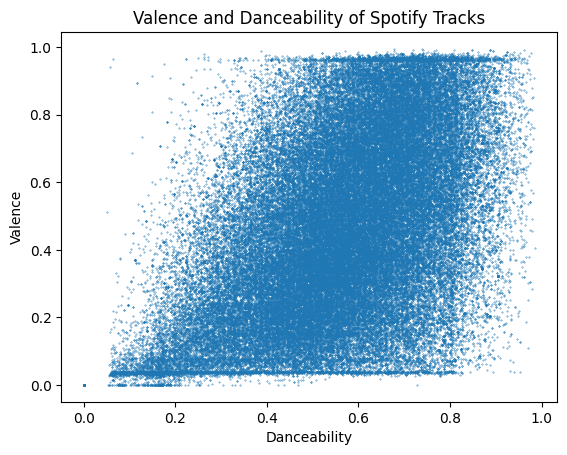

In [18]:
danceability = spotify['danceability']
energy = spotify['valence']
plt.scatter(danceability, energy, s=0.1)
plt.xlabel('Danceability')
plt.ylabel('Valence')
plt.title('Valence and Danceability of Spotify Tracks')

### Speechiness and Instrumentalness

Speechiness measures the presence of spoken words in a song, while instrumentalness predicts if a song contains no vocals. These two should be inversely related, which this graph somewhat shows.

Text(0.5, 1.0, 'Speechiness and Instrumentalness of Spotify Tracks')

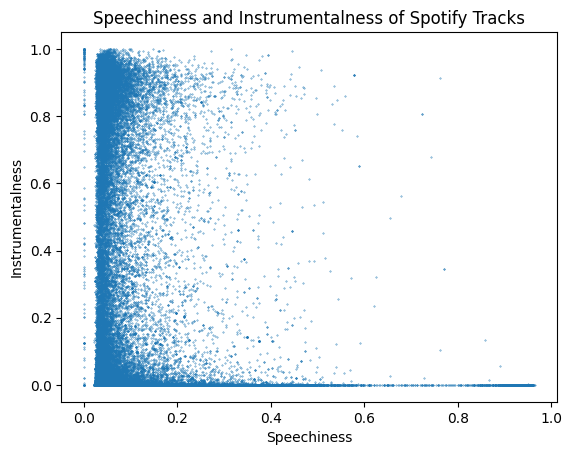

In [21]:
speechiness = spotify['speechiness']
instrumentalness = spotify['instrumentalness']
plt.scatter(speechiness, instrumentalness, s=0.1)
plt.xlabel('Speechiness')
plt.ylabel('Instrumentalness')
plt.title('Speechiness and Instrumentalness of Spotify Tracks')